# 00. Exploratory Data Analysis (EDA)

Goal: Visualize raw data, analyze returns, volatility, and properties of the EUR/USD pair.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure we can import from src/utils
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)
from utils.data_manager import DataManager

import re # Added for column cleanup

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 7)


## 1. Load Raw Data

In [2]:
dm = DataManager(data_type='raw', local_dir=os.path.join(root_path, 'data/raw'))
if not dm.is_data_current():
    print("⚠️ Data might be old. Consider running 01_ingest_data.")

df = dm.get_latest_data()
if df.empty:
    print("❌ No data found. Please run ingest pipeline firstly.")
else:
    print(f"✅ Loaded {len(df)} rows.")
    
    # Fix: Robust Cleanup for "Tuple-String" columns (e.g. "('Close', 'EURUSD=X')")
    # This happens when MultiIndex is saved to CSV and reloaded as strings.
    new_cols = []
    for c in df.columns:
        c = str(c)
        if (c.startswith("('") or c.startswith('("')) and "," in c:
            # Extract first part: "('Close', ...)" -> "Close"
            clean = c.strip("()").replace("'", "").replace('"', "").split(",")[0].strip()
            new_cols.append(clean)
        else:
            new_cols.append(c)
            
    df.columns = new_cols
    
    # Deduplicate: df.loc[:, ~df.columns.duplicated()] will keep the FIRST occurrence.
    # We want to ensure we don't lose data.
    df = df.loc[:, ~df.columns.duplicated()]
    
    # Ensure Numeric and Drop All-NaNs
    for c in ['Open', 'High', 'Low', 'Close']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            
    df = df.dropna(how='all')
    print(f"✅ Cleaned columns: {df.columns.tolist()}")
    
    display(df.tail())


✅ Loaded 1307 rows.
✅ Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


,Close,High,Low,Open,Volume
Date,,,,,
2025-12-30,1.177288,1.178134,1.174619,1.177302,0
2025-12-31,1.174950,1.176194,1.172333,1.174950,0
2026-01-02,1.172333,1.176886,1.171646,1.175226,0
2026-01-05,1.170467,1.171866,1.166004,1.170645,0
2026-01-06,1.169180,1.174812,1.168770,1.172333,0


## 2. Visualize Closing Price

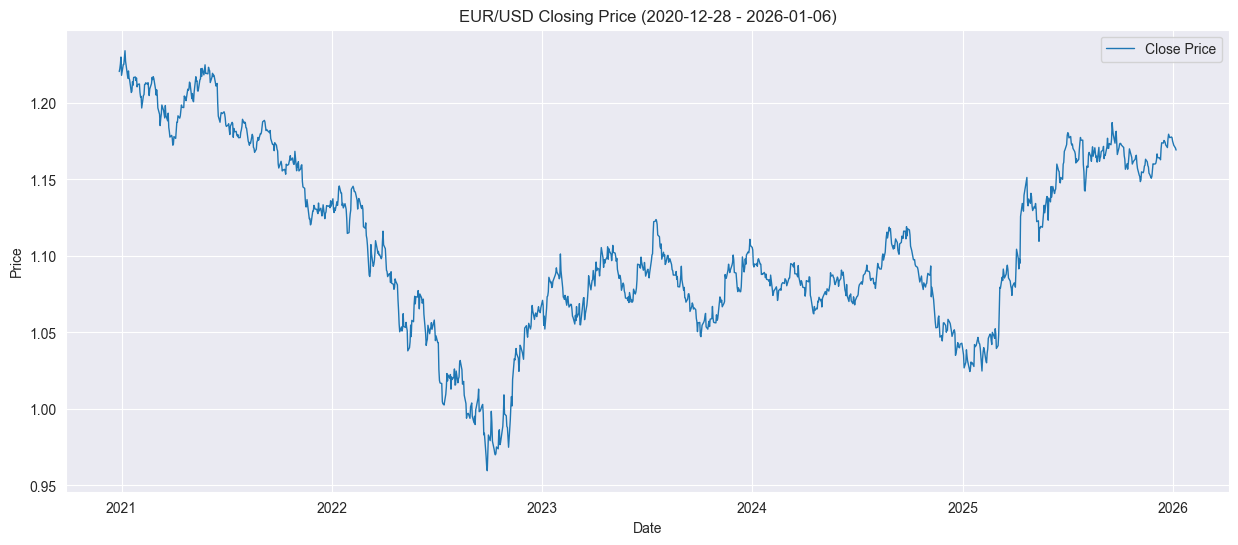

In [3]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='Close Price', linewidth=1)
plt.title(f"EUR/USD Closing Price ({df.index.min().date()} - {df.index.max().date()})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


## 3. Returns Analysis

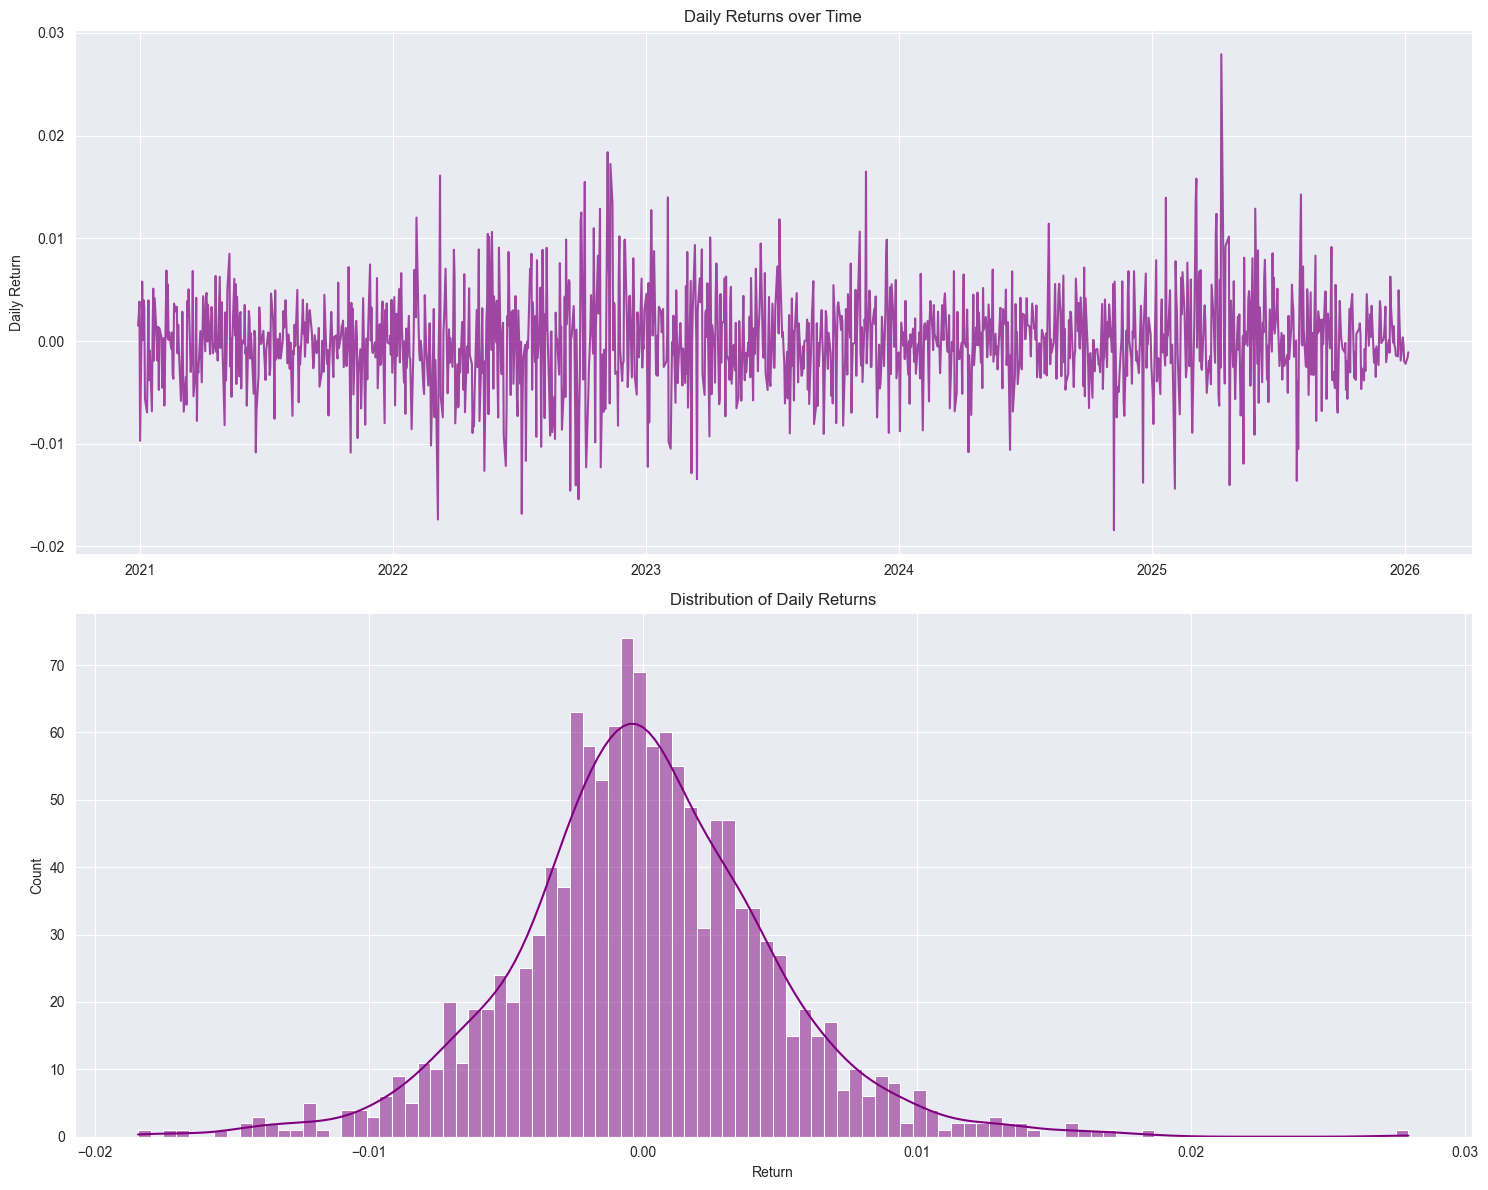

In [4]:
# Calculate Daily Returns
df['Return'] = df['Close'].pct_change()
df = df.dropna()

fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Time Series of Returns
ax[0].plot(df.index, df['Return'], color='purple', alpha=0.7)
ax[0].set_title("Daily Returns over Time")
ax[0].set_ylabel("Daily Return")

# Distribution of Returns
sns.histplot(df['Return'], bins=100, kde=True, ax=ax[1], color='purple')
ax[1].set_title("Distribution of Daily Returns")
ax[1].set_xlabel("Return")

plt.tight_layout()
plt.show()


## 4. Volatility Analysis (Rolling Standard Deviation)

Volatility is a measure of the dispersion of returns. High volatility means higher risk/opportunity.

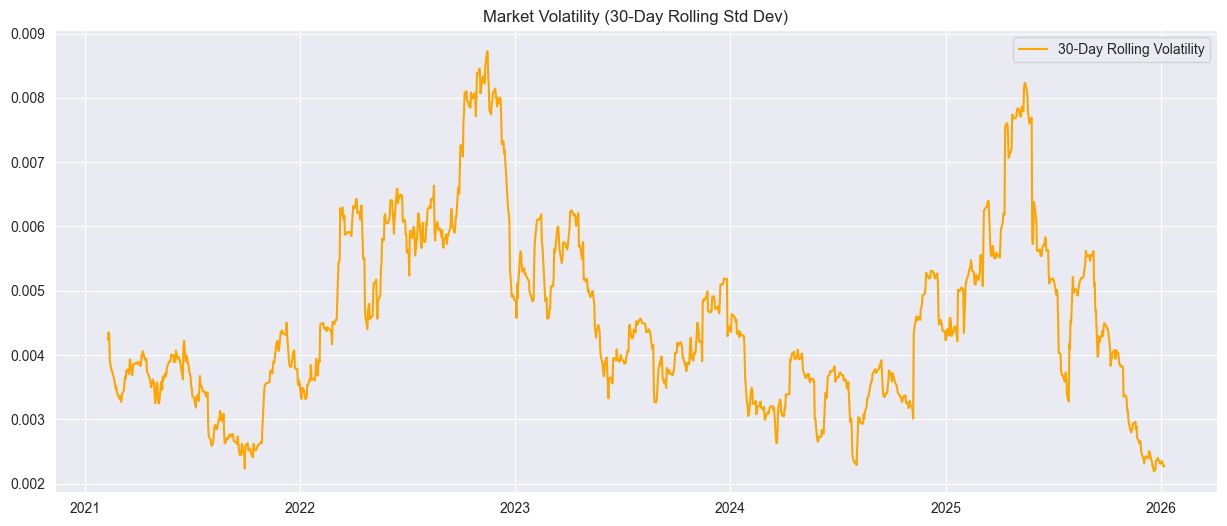

In [5]:
# 30-day Rolling Volatility (Standard Deviation of Returns)
window = 30
df['Volatility_30d'] = df['Return'].rolling(window=window).std()

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Volatility_30d'], color='orange', label=f'{window}-Day Rolling Volatility')
plt.title(f"Market Volatility ({window}-Day Rolling Std Dev)")
plt.legend()
plt.show()


## 5. Autocorrelation

Check if past returns influence future returns (Market Efficiency).

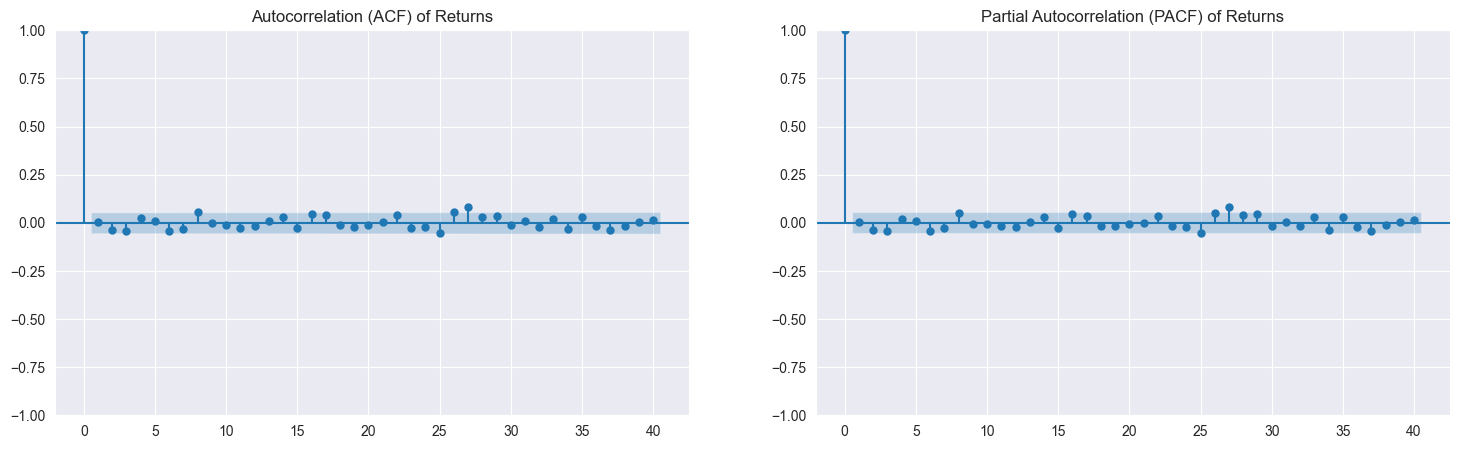

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
plot_acf(df['Return'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF) of Returns")

plot_pacf(df['Return'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF) of Returns")
plt.show()
